In [1]:
import datetime as dt
from authenticate import authenticate_google_calendar 
import matplotlib.pyplot as plt

In [2]:
def fetch_calendar_names(service):
    calendar_list = service.calendarList().list().execute()
    calendars = calendar_list.get('items', [])
    return {calendar['id']: calendar['summary'] for calendar in calendars}

calendar_name_map = fetch_calendar_names(authenticate_google_calendar())
calendar_name_map

{'en.uk#holiday@group.v.calendar.google.com': 'Holidays in United Kingdom',
 'lfsavm70glf40q34ic0335c6u1aepghe@import.calendar.google.com': 'The Perse School 2nd XI Football 2023/24 Fixture List',
 'o3ddi6qpfar9g43eldqb6ad2l6lipdml@import.calendar.google.com': 'Calendar',
 '5b70831851b9eaf56fb74981050cb210336e398780f912a418be202fd52ec25a@group.calendar.google.com': 'ClickUp',
 'billjrimell@gmail.com': 'Calendar',
 '90c68802d80f0e9b3643757199cad05eeaa8c1d02f655a7c7c5cc2c7de4d41f6@group.calendar.google.com': 'RescueTime',
 '0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com': 'Studying',
 'kpdgcc7d7qeu4sec0osde15bkg@group.calendar.google.com': 'Family',
 '6e609d607f04ff756b9050d7b8444d658f6b7c8914ded6b1066a33491b5b67e0@group.calendar.google.com': 'Time',
 'g3uv76g8h69qah3p4i80bv5233up9nd9@import.calendar.google.com': 'https://files-f1.motorsportcalendars.com/f1-calendar_p1_p2_p3_qualifying_sprint_gp.ics?t=1677426916665',
 'vbuvijqvpeglfbl39a420nj7t

In [3]:
def fetch_study_events(service, calendar_id, num_previous_days=30):
    now = dt.datetime.utcnow().isoformat() + "Z"  # 'Z' indicates UTC time
    start_date = dt.datetime.utcnow() - dt.timedelta(days=num_previous_days)
    start_date_iso = start_date.isoformat() + "Z"

    # print(f"Fetching events from {calendar_id} for the past {num_previous_days} days")
    events_result = (
        service.events()
        .list(
            calendarId=calendar_id,
            timeMin=start_date_iso,
            timeMax=now,
            maxResults=10000,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])
    print(f"Found {len(events)} events in the past {num_previous_days} days from {calendar_name_map[calendar_id]}.")

    return events

In [4]:
def merge_events(events_list):
    merged_events = []
    for events in events_list:
        merged_events.extend(events)
    return merged_events

def study_stats(service, calendar_ids, num_previous_days=365):
    all_events = []
    for calendar_id in calendar_ids:
        events = fetch_study_events(service, calendar_id, num_previous_days)
        all_events.extend(events)

    merged_events = merge_events([all_events])

    subjects = {
        "Maths": ["maths", "math", "mathematics"],
        "Computer Science": ["computer science", "comp sci", "cs nea", "csc"],
        "Physics": ["physics", "phys"],
        "EPQ": ["epq"],
        "TMUA": ["tmua"],
        "Project Euler": ["project euler"],
        "Medium": ["medium"],
    }
    subjects_time = {subject: 0 for subject in subjects}

    for event in merged_events:
        start = dt.datetime.fromisoformat(
            event["start"].get("dateTime", event["start"].get("date"))
        )
        end = dt.datetime.fromisoformat(
            event["end"].get("dateTime", event["end"].get("date"))
        )
        duration = (end - start).total_seconds() / 3600  # Convert to hours

        summary = event.get("summary", "")

        # print(f"{start.strftime('%Y-%m-%d %H:%M')} - {end.strftime('%Y-%m-%d %H:%M')}: {summary} ({duration:.1f} hrs)")
        for subject, terms in subjects.items():
            for term in terms:
                if term.lower() in summary.lower():
                    subjects_time[subject] += duration
                    break

    if sum(subjects_time.values()) == 0:
        print(f"No study time recorded for the past {num_previous_days} days.")
        return

    total_study_time = sum(subjects_time.values())
    print(f"Total study time in the past {num_previous_days} days: {total_study_time} hours")

    for subject, time in subjects_time.items():
        if time > 0:
            print(f"{subject}: {time:.1f} hrs", end=", ")
    print()

    # Generate pie chart and bar chart side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pie chart
    ax1.pie(
        [x for x in subjects_time.values() if x > 0],
        labels=[x for x in subjects_time if subjects_time[x] > 0],
        autopct="%1.1f%%",
        startangle=90,
    )
    ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")

    # Bar chart
    ax2.bar(subjects_time.keys(), subjects_time.values())
    ax2.set_xlabel("Subjects")
    ax2.set_ylabel("Study Time (hours)")
    ax2.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

Found 596 events in the past 365 days from Studying.
Found 596 events in the past 365 days from Calendar.
Total study time in the past 365 days: 553.65 hours
Maths: 209.3 hrs, Computer Science: 89.5 hrs, Physics: 106.3 hrs, EPQ: 80.6 hrs, TMUA: 60.4 hrs, Project Euler: 4.5 hrs, Medium: 3.0 hrs, 


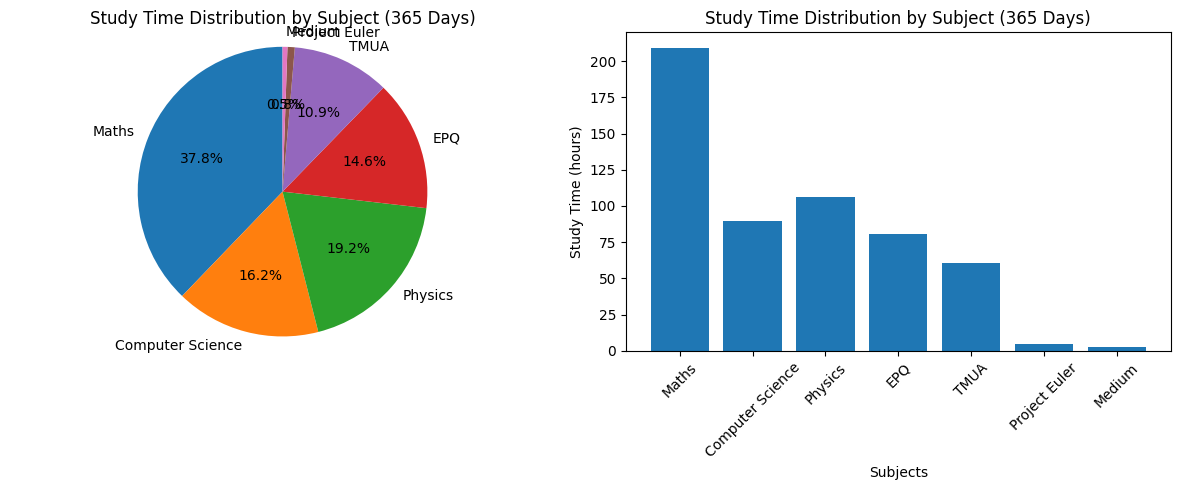

Found 18 events in the past 30 days from Studying.
Found 18 events in the past 30 days from Calendar.
Total study time in the past 30 days: 38.166666666666664 hours
Computer Science: 2.5 hrs, TMUA: 28.2 hrs, Project Euler: 4.5 hrs, Medium: 3.0 hrs, 


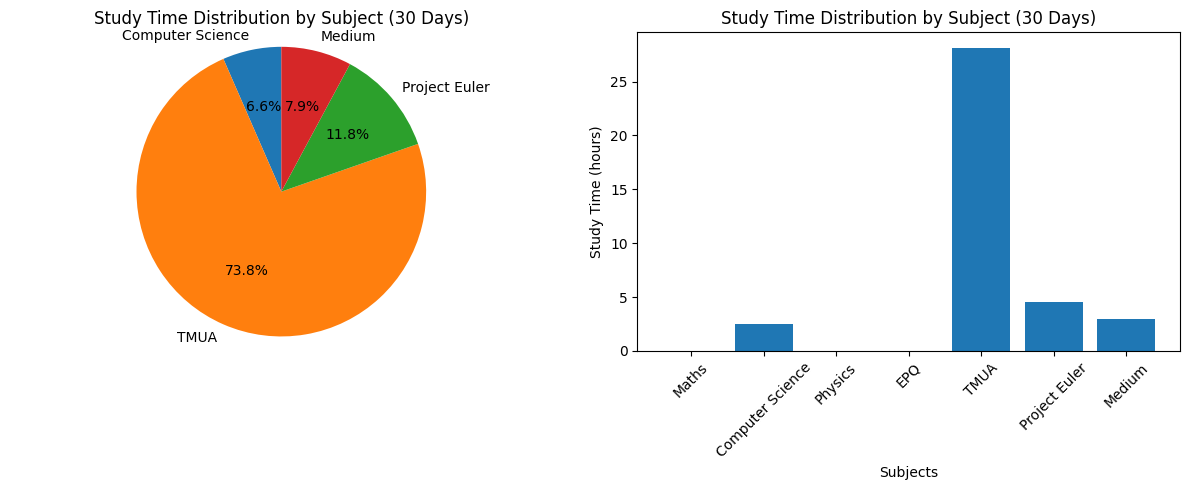

Found 0 events in the past 7 days from Studying.
Found 1 events in the past 7 days from Calendar.
No study time recorded for the past 7 days.


In [5]:
service = authenticate_google_calendar()
calendar_ids = [
    "0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com",
    "billjrimell@gmail.com",
    # "b7ca60b7b46309b1e408a4a240a5456ca98cb4af51ad62d260ae8ae4fd0ce45d@group.calendar.google.com" # timetable
]

# Generate statistics and plots for different time periods
for days in [365, 30, 7]:
    study_stats(service, calendar_ids, num_previous_days=days)